<a href="https://colab.research.google.com/github/DorSkoler/BigData/blob/main/plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -O ./spark-3.3.1-bin-hadoop3.tgz  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar zxvf ./spark-3.3.1-bin-hadoop3.tgz
!pip install findspark

--2023-02-14 19:02:06--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299350810 (285M) [application/x-gzip]
Saving to: ‘./spark-3.3.1-bin-hadoop3.tgz’

./spark-3.3.1-bin-h 100%[===================>] 285.48M   215MB/s    in 1.3s    

2023-02-14 19:02:08 (215 MB/s) - ‘./spark-3.3.1-bin-hadoop3.tgz’ saved [299350810/299350810]

spark-3.3.1-bin-hadoop3/
spark-3.3.1-bin-hadoop3/LICENSE
spark-3.3.1-bin-hadoop3/NOTICE
spark-3.3.1-bin-hadoop3/R/
spark-3.3.1-bin-hadoop3/R/lib/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.1-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3

In [2]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

In [3]:
import findspark
import random
findspark.init()

In [41]:
# Other imports
import numpy as np
import pyspark
import math
from pyspark.rdd import RDD
from pyspark import SparkContext
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from numpy.lib.function_base import average

In [5]:
spark = SparkSession \
    .builder \
    .appName("house-prices") \
    .getOrCreate()

In [8]:
zhvi_df = spark.read.csv('/content/sample_data/City_zhvi_month.csv', multiLine=True, inferSchema=True, header=True)
zori_df = spark.read.csv('/content/sample_data/City_zori_month.csv', multiLine=True, inferSchema=True, header=True)

In [9]:
oldColumns = zori_df.schema.names
newColumns = zori_df.schema.names[0:8] + ['rent_' + x for x in zori_df.schema.names[8:]]

zori_df = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), zori_df)
zori_df.printSchema()
zori_df.show()

root
 |-- RegionID: integer (nullable = true)
 |-- SizeRank: integer (nullable = true)
 |-- RegionName: string (nullable = true)
 |-- RegionType: string (nullable = true)
 |-- StateName: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Metro: string (nullable = true)
 |-- CountyName: string (nullable = true)
 |-- rent_2015-03-31: double (nullable = true)
 |-- rent_2015-04-30: double (nullable = true)
 |-- rent_2015-05-31: double (nullable = true)
 |-- rent_2015-06-30: double (nullable = true)
 |-- rent_2015-07-31: double (nullable = true)
 |-- rent_2015-08-31: double (nullable = true)
 |-- rent_2015-09-30: double (nullable = true)
 |-- rent_2015-10-31: double (nullable = true)
 |-- rent_2015-11-30: double (nullable = true)
 |-- rent_2015-12-31: double (nullable = true)
 |-- rent_2016-01-31: double (nullable = true)
 |-- rent_2016-02-29: double (nullable = true)
 |-- rent_2016-03-31: double (nullable = true)
 |-- rent_2016-04-30: double (nullable = true)
 |-- rent_2016

In [10]:
newDF = zhvi_df.join(zori_df,zhvi_df.RegionID ==  zori_df.RegionID,"inner")

In [11]:
newDF.show(20)

+--------+--------+-------------+----------+---------+-----+--------------------+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------

In [12]:
def plot_this(x, y):
  sns.lineplot(y=y, x=x)
  plt.show()

In [13]:
fields_zori = []
for x in zori_df.schema[8:]:
  fields_zori.append(x.name)
len(fields_zori)

fields_zhvi = []
for x in fields_zori:
  y = x.replace('rent_', '')
  fields_zhvi.append(y)
len(fields_zhvi)

93

In [15]:
def monthlyYield(houseValue, rentValue, houseValueNextMonth):
  if houseValue is None or rentValue is None or houseValueNextMonth is None:
    return 0
  return ((rentValue / houseValue) + (houseValueNextMonth / houseValue))

In [16]:
def yearlyYield(houseValue, rentValue, houseValueNextMonth):
  if houseValue is None or rentValue is None or houseValueNextMonth is None:
    return 0
  return ((rentValue / houseValue) * 12 + (houseValueNextMonth / houseValue))

In [56]:
def plots_lists(avgL, yieldL):
  default_value = -1e20
  for obj, value in avgL.items():
    if math.isnan(value):
        avgL[obj] = default_value

  regionMaxs = sorted(avgL, reverse=True, key=avgL.get)[:5]
  for regionMax in regionMaxs:
    print(f"in {regionMax} the average yield is: {avgL[regionMax]}")
    print(f"data available for {len(yieldL[regionMax])} months")
    plot_this(fields_zori[:len(yieldL[regionMax])],yieldL[regionMax])

In [26]:
zhvi_df_metro = spark.read.csv('/content/sample_data/Metro_zhvi_month.csv', multiLine=True, inferSchema=True, header=True)
zori_df_metro = spark.read.csv('/content/sample_data/Metro_zori_month.csv', multiLine=True, inferSchema=True, header=True)

In [83]:
def combineDfs(zhvi, zori):
  oldColumns = zori.schema.names
  newColumns = zori.schema.names[0:8] + ['rent_' + x for x in zori.schema.names[8:]]
  zori = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), zori)
  return zhvi.join(zori,zhvi.RegionID ==  zori.RegionID,"inner")

In [84]:
fields_zori_metro = zori_df_metro.schema.names[5:]
metro_df = combineDfs(zhvi_df_metro, zori_df_metro)

In [80]:
def makeAvgYieldLists(df, minMonths, fields_zori, print_values):
  yieldList = {}
  avgList = {}
  for row in df.collect():
    yieldList[row['RegionName']] = []
    for index in range(len(fields_zori) - 1):
      month = monthlyYield(row[fields_zori[index].replace('rent_', '')], row[fields_zori[index]], row[fields_zori[index + 1]])
      if month != 0:
        yieldList[row['RegionName']].append(round(month * 100, 2))
    avgList[row['RegionName']] = average(yieldList[row['RegionName']])
    if print_values:
      print(f"total avg yield - {avgList[row['RegionName']]}%, in - {row['RegionName']}")

  toRemove = []
  for city, ylist in yieldList.items():
    if len(ylist) < minMonths:
      toRemove.append(city)
  for city in toRemove:
    del yieldList[city]
    del avgList[city]
  return avgList, yieldList

In [81]:
city_avg, city_yield = makeAvgYieldLists(newDF, 30, fields_zori, False)

metro_avg, metro_yield = makeAvgYieldLists(newDF_metro, 30, fields_zori_metro, False)

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


in Detroit the average yield is: 5.004021739130435
data available for 92 months


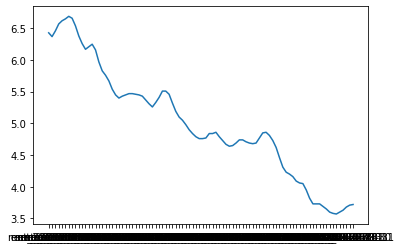

in Gary the average yield is: 3.6581690140845073
data available for 71 months


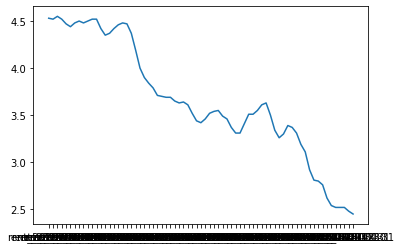

in Pontiac the average yield is: 2.592111111111111
data available for 90 months


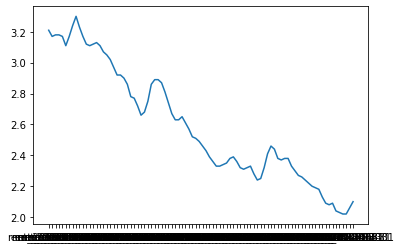

in Dayton the average yield is: 2.2556521739130435
data available for 92 months


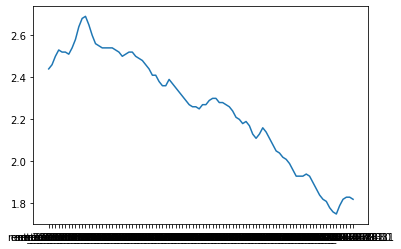

in Toledo the average yield is: 2.237282608695652
data available for 92 months


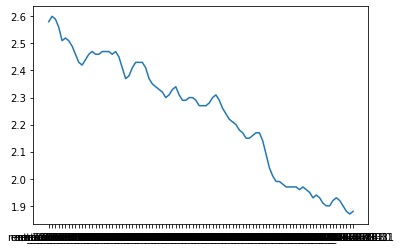

In [79]:
plots_lists(city_avg, city_yield)

in Glenwood Springs, CO the average yield is: 4.044625
data available for 80 months


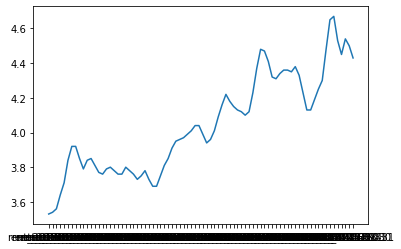

in Jackson, MS the average yield is: 1.637948717948718
data available for 78 months


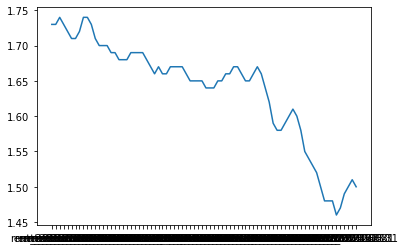

in El Paso, TX the average yield is: 1.632934782608696
data available for 92 months


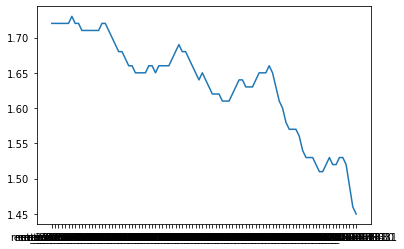

in Valdosta, GA the average yield is: 1.6163636363636364
data available for 88 months


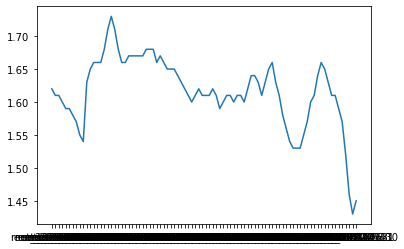

in McAllen, TX the average yield is: 1.600869565217391
data available for 92 months


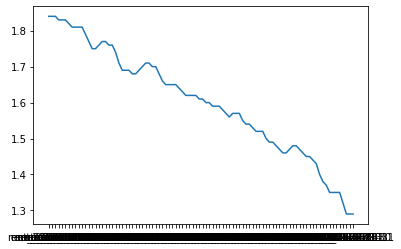

In [82]:
plots_lists(metro_avg, metro_yield)

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -O ./spark-3.3.1-bin-hadoop3.tgz  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar zxvf ./spark-3.3.1-bin-hadoop3.tgz
!pip install findspark

--2023-02-14 21:04:16--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299350810 (285M) [application/x-gzip]
Saving to: ‘./spark-3.3.1-bin-hadoop3.tgz’

./spark-3.3.1-bin-h 100%[===================>] 285.48M   156MB/s    in 1.8s    

2023-02-14 21:04:18 (156 MB/s) - ‘./spark-3.3.1-bin-hadoop3.tgz’ saved [299350810/299350810]

spark-3.3.1-bin-hadoop3/
spark-3.3.1-bin-hadoop3/LICENSE
spark-3.3.1-bin-hadoop3/NOTICE
spark-3.3.1-bin-hadoop3/R/
spark-3.3.1-bin-hadoop3/R/lib/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.1-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"
import findspark
import random
findspark.init()
# Other imports
import numpy as np
import math
import pyspark
from pyspark.rdd import RDD
from pyspark import SparkContext
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from numpy.lib.function_base import average

In [11]:
spark = SparkSession \
    .builder \
    .appName("house-prices") \
    .getOrCreate()

In [33]:
zhvi_df = spark.read.csv('/content/sample_data/City_zhvi_month.csv', multiLine=True, inferSchema=True, header=True)
zori_df = spark.read.csv('/content/sample_data/City_zori_month.csv', multiLine=True, inferSchema=True, header=True)

zhvi_df_metro = spark.read.csv('/content/sample_data/Metro_zhvi_month.csv', multiLine=True, inferSchema=True, header=True)
zori_df_metro = spark.read.csv('/content/sample_data/Metro_zori_month.csv', multiLine=True, inferSchema=True, header=True)

In [32]:
def combineDfs(zhvi, zori, valuesStart):
  oldColumns = zori.schema.names
  newColumns = zori.schema.names[0:valuesStart] + ['rent_' + x for x in zori.schema.names[valuesStart:]]
  zori = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), zori)
  return zhvi.join(zori,zhvi.RegionID ==  zori.RegionID,"inner")

def plot_this(x, y):
  sns.lineplot(y=y, x=x)
  plt.show()

def monthlyYield(houseValue, rentValue, houseValueNextMonth):
  if houseValue is None or rentValue is None or houseValueNextMonth is None:
    return 0
  return ((rentValue / houseValue) + (houseValueNextMonth / houseValue))

def yearlyYield(houseValue, rentValue, houseValueNextMonth):
  if houseValue is None or rentValue is None or houseValueNextMonth is None:
    return 0
  return ((rentValue / houseValue) * 12 + (houseValueNextMonth / houseValue))

def plots_lists(avgL, yieldL, fields):
  default_value = -1e20
  for obj, value in avgL.items():
    if math.isnan(value):
        avgL[obj] = default_value

  regionMaxs = sorted(avgL, reverse=True, key=avgL.get)[:5]
  for regionMax in regionMaxs:
    print(f"in {regionMax} the average yield is: {avgL[regionMax]}")
    print(f"data available for {len(yieldL[regionMax])} months")
    plot_this(fields[:len(yieldL[regionMax])],yieldL[regionMax])

def makeAvgYieldLists(df, minMonths, fields, print_values):
  yieldList = {}
  avgList = {}
  for row in df.collect():
    yieldList[row['RegionName']] = []
    for index in range(len(fields) - 1):
      month = monthlyYield(row[fields[index].replace('rent_', '')], row[fields[index]], row[fields[index + 1]])
      if month != 0:
        yieldList[row['RegionName']].append(round(month * 100, 2))
    avgList[row['RegionName']] = average(yieldList[row['RegionName']])
    if print_values:
      print(f"total avg yield - {avgList[row['RegionName']]}%, in - {row['RegionName']}")

  toRemove = []
  for city, ylist in yieldList.items():
    if len(ylist) < minMonths:
      toRemove.append(city)
  for city in toRemove:
    del yieldList[city]
    del avgList[city]
  return avgList, yieldList

In [34]:
city_fields = zori_df.schema.names[8:]

metro_fields = zori_df_metro.schema.names[5:]

city_df = combineDfs(zhvi_df, zori_df, 8)

metro_df = combineDfs(zhvi_df_metro, zori_df_metro, 5)

In [29]:
city_df.show(10)

+--------+--------+------------+----------+---------+-----+--------------------+-------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------

In [30]:
metro_df.show(10)

+--------+--------+----------------+----------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------

In [37]:
city_avg, city_yield = makeAvgYieldLists(city_df, 30, city_fields, True)

metro_avg, metro_yield = makeAvgYieldLists(metro_df, 30, metro_fields, False)

total avg yield - 200.40141304347827%, in - New York
total avg yield - 200.5854347826087%, in - Los Angeles
total avg yield - 200.5996739130435%, in - Houston
total avg yield - 200.40184782608696%, in - Chicago
total avg yield - 200.69054347826085%, in - San Antonio
total avg yield - 200.90304347826088%, in - Phoenix
total avg yield - 200.6253260869565%, in - Philadelphia
total avg yield - 200.84521739130432%, in - Las Vegas
total avg yield - 200.7167391304348%, in - San Diego
total avg yield - 200.87576086956523%, in - Dallas
total avg yield - 200.7167777777778%, in - Austin
total avg yield - 200.6652173913044%, in - San Jose
total avg yield - 200.89217391304345%, in - Jacksonville
total avg yield - 200.90141304347827%, in - Charlotte
total avg yield - 200.34195652173912%, in - San Francisco
total avg yield - 200.81076086956517%, in - Indianapolis
total avg yield - 200.9023913043478%, in - Fort Worth
total avg yield - 200.8013043478261%, in - Tucson
total avg yield - 200.8271739130434

in East Lake-Orient Park the average yield is: 201.44815217391303
data available for 92 months


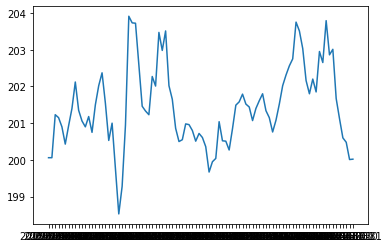

in Palm River-Clair Mel the average yield is: 201.3827173913043
data available for 92 months


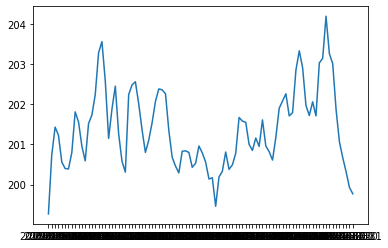

in Forest Park the average yield is: 201.3691304347826
data available for 92 months


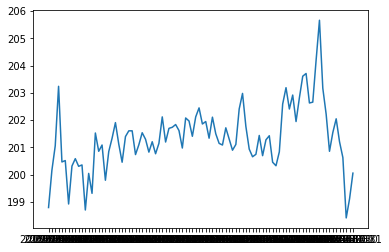

in Gladeview the average yield is: 201.3604347826087
data available for 92 months


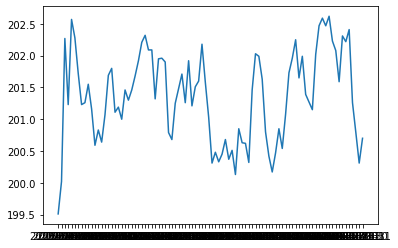

in Port Richey the average yield is: 201.3598888888889
data available for 90 months


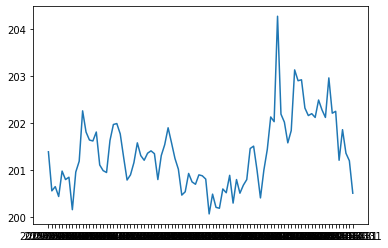

In [36]:
plots_lists(city_avg, city_yield)

in Burlington, NC the average yield is: 201.19847826086954
data available for 46 months


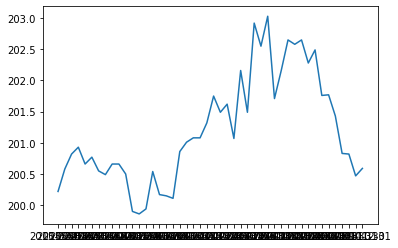

in Aberdeen, WA the average yield is: 201.17554347826083
data available for 92 months


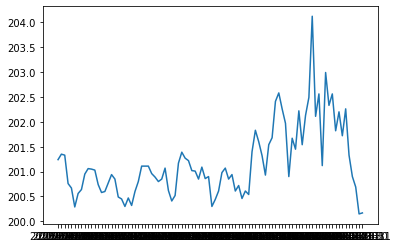

in Key West, FL the average yield is: 201.04931818181822
data available for 44 months


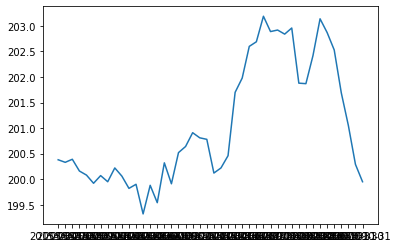

in Idaho Falls, ID the average yield is: 201.0256521739131
data available for 92 months


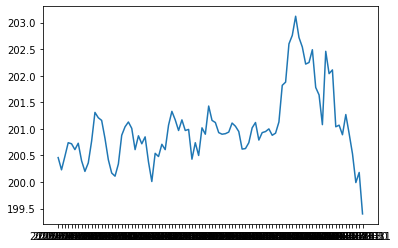

in Homosassa Springs, FL the average yield is: 201.02228260869563
data available for 92 months


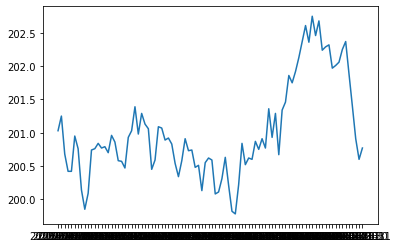

In [24]:
plots_lists(metro_avg, metro_yield)